# Recommender System

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
from io import StringIO

# Familiarization

First, we will load the entire dataset and visualize it to get a first look at what we are dealing with. We have decided to visualize the given data as a matrix where on column i we can see which people the person with id i liked/disliked by checking each line and putting either a green dot if they liked the person with id j (line j), or a red dot if they disliked them.

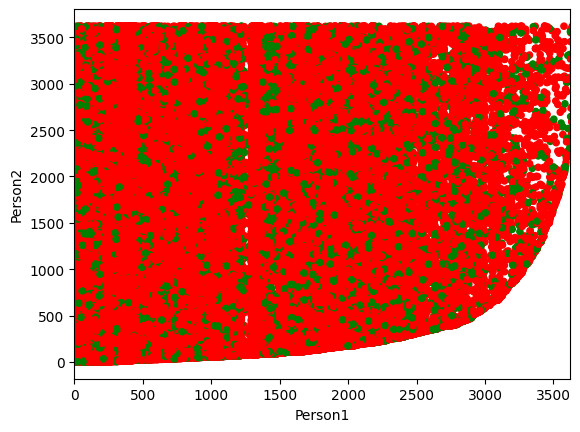

In [309]:
train_file_path = 'lab2_train.csv'

pd.set_option('display.max_rows', None)
raw_data = pd.read_csv(train_file_path, delimiter=',', skipinitialspace= True)
#dropping the column related to matches as is mentioned in the assignment description
raw_data = raw_data.drop('is_match',axis=1)

def visualize_data(df, window=None, title=None):
    if window is None:
        start_index = 0
        end_index = train_data['user_to_id'].max()
    else:
        start_index, end_index = window
    colors = df['is_like'].map({True: 'green', False: 'red'})
    plt.scatter(df['user_from_id'], df['user_to_id'], c=colors, s=20)

    plt.xlim(start_index,end_index)

    plt.xlabel('Person1')
    plt.ylabel('Person2')

    if title is not None:
        plt.title(title)

    plt.show()

visualize_data(raw_data)

On a first glance, one can easily see that users with id greater than ~2500 rate(like/dislike) a lot less than the others. There are also certain groups(intervals of columns) of people that like a lot/dislike a lot. To show a couple of examples, we will plot a few smaller window of columns that demonstrate users that mostly dislike others, and also print a list of the people who have only ever liked others, without any dislikes.

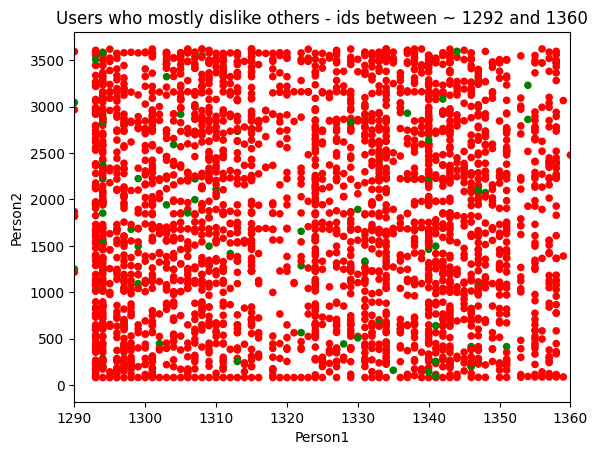

Partial ist of the ids of users who only liked others.
[3604, 3608, 3212, 3663, 3674, 7, 2530, 3607, 2907, 3050]


In [310]:
visualize_data(raw_data, (1290,1360), "Users who mostly dislike others - ids between ~ 1292 and 1360")

id_counts = list(raw_data[(raw_data['is_like'] == True) | (raw_data['is_like'] == False)]['user_from_id'].value_counts().items())
filtered_data = raw_data[raw_data['is_like'] == True]
like_counts = list(filtered_data['user_from_id'].value_counts().items())

all_likes_tuples = list(set(id_counts) & set(like_counts))
all_likes = [v[0] for v in all_likes_tuples]
print("Partial ist of the ids of users who only liked others.")
print(all_likes[:10])

Thus, we can observe that multiple types of people exist in our dataset. There are also examples of intervals where a lot of users did not have any type of interaction, i.e between 1250 and 1300, most users seem to not have many if any interactions at all.

# Preprocessing

 First, we will have to do some preprocessing on our training dataframe. After a lot of trial and error, we have decided to:
- remove the duplicate lines, only keeping unique instances of lines
- remove rows where a user first liked a person and then disliked them, or the other way around(due to inconsistency in data) Example: user 1 liked user 2, and then disliked them afterwards. We are deleting both rows.
- remove ids of users who have never liked someone, meaning either only dislikes
- remove ids of people who have less than a certain threshold of interactions(times they appear in the dataframe) 

In our tests, the removal of such outliers has shown to improve our algorithm's accuracy and, at the same time, make a lot of sense to us in order to maintain consistency and fairness in our data. In order to put in practice the above points, we created the function below that takes a dataframe and returns a filtered one:

In [311]:
def preprocess(data, min_interactions = 5):
    # removing duplicate lines
    train_data = data
    train_data = train_data.drop_duplicates()
    
    # removing inconsistent ids(described above)
    mask = train_data.duplicated(subset=['user_from_id', 'user_to_id'],keep=False)
    train_data = train_data[~mask]

    # removing ids that have only disliked others
    false_ids = train_data.loc[~train_data.groupby('user_from_id')['is_like'].transform('any')]['user_from_id'].to_list() #list of ids to be removed
    train_data = train_data[~train_data['user_from_id'].isin(false_ids)]
    
    # removing ids of people with a small amount of interactions
    counts_list = list(train_data['user_from_id'].value_counts().items())
    relevant_ids = [id for id, count in counts_list if count>=min_interactions]
    train_data = train_data[train_data['user_from_id'].isin(relevant_ids)]
    train_data = train_data.reset_index(drop=True)
    return train_data

To better visualize the effects of our pre-processing, let's see its effects on the following, simpler, dataset:

In [312]:
data_string = """user_from_id,user_to_id,is_like,is_match
1136,3141,True,False
1136,3174,False,False
1136,3590,False,False
800,2736,False,False
883,437,True,False
311,625,False,False
8,1122,False,False
883,437,True,False
883,437,False,False
1,2,True,False
883,23,True,False
883,32,False,False
1,3,True,False
1,4,True,False
1,5,True,False
1,6,True,False
1,6,True,False
311,53243,False,False
311,23,False,False
311,543,False,False
311,345325,False,False"""
simple_train_data = pd.read_csv(StringIO(data_string))
simple_train_data = simple_train_data.drop('is_match',axis=1)
print(simple_train_data)

    user_from_id  user_to_id  is_like
0           1136        3141     True
1           1136        3174    False
2           1136        3590    False
3            800        2736    False
4            883         437     True
5            311         625    False
6              8        1122    False
7            883         437     True
8            883         437    False
9              1           2     True
10           883          23     True
11           883          32    False
12             1           3     True
13             1           4     True
14             1           5     True
15             1           6     True
16             1           6     True
17           311       53243    False
18           311          23    False
19           311         543    False
20           311      345325    False


In [313]:
# Filtering our data
filtered_simple_data = preprocess(simple_train_data,2)
print(filtered_simple_data)

   user_from_id  user_to_id  is_like
0          1136        3141     True
1          1136        3174    False
2          1136        3590    False
3             1           2     True
4           883          23     True
5           883          32    False
6             1           3     True
7             1           4     True
8             1           5     True
9             1           6     True


Here, we can see the effects of our preprocessing: 
- The like from user 1 to user 6 only appears once
- User 883 liked 437 twice and disliked once, thus we don't include the matching of 883 to 437 at all
- User 311 only disliked users (many interactions though), so it is not included
- Users 800 and 8 only had one interaction

Let's apply the preprocessing now to our data:

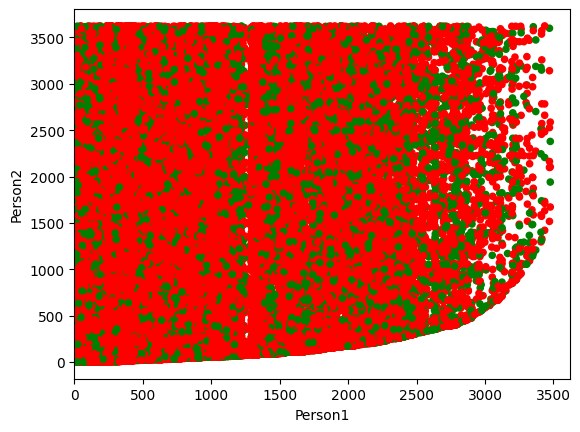

3149
1846


In [314]:
train_data = preprocess(raw_data)
visualize_data(train_data)
print(len(set(raw_data["user_from_id"])))
print(len(set(train_data["user_from_id"])))

We can see that we lose quite a bit of information (users whose preferences will be taken into consideration). However, since we are dealing with real data, with consider this to be expected, since many apps are used by people in a superficial / disinterested manner, without making truthful and honest decisions - and including such data can lead to an ultimate loss in our recommender's performance.

# NMF-based recommender system
We will now apply our NMF algorithm on the dataset in order to then reconstruct the matrix for a proper recommender system.

!!! SCRIE AICI IONITA !!!

# Distance-based recommender system

Next, we will adopt a different approach to the task of coming up with a new recommendation for a user. To build a basic intuition, we will first build a new utility matrix where both rows and columns each contain distinct user ids, and a 1 in row `i`, column `j`, would signify that user with id `j` liked user with id `i`.

Next, in order to identify two users with similar behaviour, one can directly compute the Jaccard distance between two columns and consider pairs that are very "close" to each other. To optimize issues with sparsity in data and adopt an automatic feature extraction technique, we will use min-hashing to compute a signature for each column, and then only compare these signatures.

This is the function that computes the algorithm:

In [315]:
class HashFunction:
    """
    This HashFunction class can be used to create a unique hash given a seed (useful for the reproducibility of results)
    """
    def __init__(self, seed, bigPrime = 805306457):
        self.bigPrime = bigPrime
        self.seed = seed
        random.seed(seed)
        self.alpha = random.choice(range(1,bigPrime))
        self.beta = random.choice(range(0,bigPrime))

    def compute_value(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: Defining the range of outputs of the function [0,n-1]
        :return: The hashed value x given the seed
        """
        return ((self.alpha * x + self.beta) % self.bigPrime)  % n

def compute_signature(ids: list[set[int]], number_hash_functions = 100, hashes_seed = 32):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param ids: The list of sets of ids -> the i-th element in this list represent the users liked by the i-th user
    :param number_hash_functions: The number of hash function we will be using
    :param hashes_seed: The seed for generating the list of seeds, used for generating the hash functions
    :return: The MinHash signature matrix for the given sets of ids, with number_hash_functions rows and as many columns as users for which have liked someone else
    """
    
    # First we need to generate the hash functions we will be using - note that the actual hash functions will be different between them, but the same in every run 
    random.seed(hashes_seed)
    hash_functions = [HashFunction(random.random()) for _ in range(number_hash_functions)]
    
    # This will be the matrix we return
    result = np.full((number_hash_functions, len(ids)), sys.maxsize)
    
    # A sorted set of the ids of the liked users (Defining the columns of the utility matrix)
    sorted_space = sorted(set().union(*ids))

    # For each liked user B
    for row_idx, row_el in enumerate(sorted_space):
        # For each liker user A
        for col_idx in range(len(ids)):
            # Did A like B?
            if row_el in ids[col_idx]:
                # Update the values of A's signature with minimal values of the hash functions, computed over the row_idx of B
                for h_idx,h in enumerate(hash_functions):
                    if result[h_idx][col_idx] > h.compute_value(row_idx, len(sorted_space)):
                        result[h_idx][col_idx] = h.compute_value(row_idx, len(sorted_space))
    return result

We will use the already pre-processed dataset, to generate a set of the id's of liked users.

In [316]:
train_data = preprocess(raw_data)
print(train_data.sort_values(by=['user_from_id'])[:10])

# First, extract the user ids who have liked others and sort this list (each user will thus be associated with his index in this list)
user_liker_list = list(sorted(set(list(train_data["user_from_id"]))))
print(user_liker_list[:10])

# Create a list of sets to store the user IDs of users liked by each user
user_to_liked_list = []

# Initialize an empty set for each user
for _ in user_liker_list:
    user_to_liked_list.append(set())

# Fill the sets with user IDs liked by each user in user_to_liked_list
for index, row in train_data.iterrows():
    user_from_id = row["user_from_id"]
    user_to_id = row["user_to_id"]
    # Find the index of the user_from_id in user_liker_list
    liker_index = user_liker_list.index(user_from_id)
    # Add the liked user_to_id to the corresponding set in the list
    user_to_liked_list[liker_index].add(user_to_id)

print(user_to_liked_list[:2]) 

       user_from_id  user_to_id  is_like
14203             1        1314    False
38383             1        1217    False
48115             1        2935    False
8632              1        2775    False
4413              1         612    False
11966             1         240    False
45593             1        1483    False
33767             1         865    False
6677              1        1820    False
44602             1        3519    False
[1, 3, 10, 14, 16, 17, 18, 19, 20, 21]
[{2448, 1820, 1314, 2339, 2088, 2935, 1595, 3519, 1217, 837, 3271, 1992, 75, 1483, 1869, 2775, 1249, 865, 612, 3046, 3047, 1519, 240, 1143}, {448, 837, 1703, 2088, 1869, 1299, 1179, 2588}]


Now, let's compute the signature matrix for the users in `user_liker_list`: 

In [317]:
signature_matrix = compute_signature(user_to_liked_list)

# Let's visualise the signature for a few columns
for _ in range(10):
    index = random.choice(range(0,signature_matrix.shape[1]))
    print(f"Signature corresponding to the user with id {user_liker_list[index]}:")
    print(str(signature_matrix[:,index]) + '\n')


Signature corresponding to the user with id 531:
[165 352 171  47  97 229 144   7  59  90 184  23 139  26  69 148  34 332
  31 270 418  25 201  19 137  81  27  79 132  96 280 461  19 150  45 105
  96 284 206 466 207   0  23 132 113 215  89 185  15  57  21 125 270  70
 111  22   9 108   8  86  38 107   0  57  94  37  37   6 133 223 250   1
 376 201 104  30 213 171 177  64  55  43   9 144 124  24 139 101 250  74
  80 277  97 284  17 131 130 132 220 124]

Signature corresponding to the user with id 163:
[1249  378  564  326  163  130   12  214  398  348  184   23 1481  486
  123   56  200  470  200  307   63  882  415  479  755   95  247  473
  149  198  591  628   47  307   80  105  172  341   97  110  103  263
  355  311  170   51  108  254 1253  370  146  489  157  594  669  296
  364  266  324   86  141  107  114   57   33  143   37   11  188  178
  165  379  575  461    8   40 1069  309  548  494  126  116 1035   97
   32  116   94  362  429  142  124    2  133 1025  332  169  902  8

Now using this **signature matrix**, we can start looking for similar users. To do this, one option would be to find all pairs of columns / "taste profiles" / signatures which are exactly the same.

In [318]:
elements, counts = np.unique(signature_matrix, axis=1, return_counts=True)

no_elements_with_pair = 0;
for (element, count) in zip(elements.T, counts):
    if count > 1:
        no_elements_with_pair += count

print(no_elements_with_pair)
print(len(user_liker_list))

0
1846


We can see that in this way, no two users have exactly the same signature matrix, an expected fact, given that we are using 100 hash functions. If we were to use less, we would obtain some pairs, granted, not many.

In [319]:
simplified_signature_matrix = compute_signature(user_to_liked_list, number_hash_functions=6)
elements, counts = np.unique(simplified_signature_matrix, axis=1, return_counts=True)
no_elements_with_pair = 0;
signatures_of_interest = []
for (element, count) in zip(elements.T, counts):
    if count > 1:
        signatures_of_interest.append(element)
        no_elements_with_pair += count
print(no_elements_with_pair)
print(signatures_of_interest)

2
[array([150, 179, 142, 109,  50,   0], dtype=int64)]


Here, when using 6 hash functions, we get exactly one pair of matching signatures. Let's find the two users whose signature it is, and the users they liked.

In [320]:
sig = signatures_of_interest[0]
colIdx1 = 0
colIdx2 = 0
for idx, row in enumerate(simplified_signature_matrix.T):
    if np.array_equal(sig, row):
        if colIdx1 == 0:
            colIdx1 = idx
        else:
            colIdx2 = idx
        
userId1 = user_liker_list[colIdx1]
userId2 = user_liker_list[colIdx2]
setLikes1 = user_to_liked_list[colIdx1]
setLikes2 = user_to_liked_list[colIdx2]
            
print(f"Users liked by user with id {userId1}: \n{sorted(setLikes1)}")
print(f"Users liked by user with id {userId2}: \n{sorted(setLikes2)}")

def jaccard_similarity(set1, set2):
    no_common_items = len(set1.intersection(set2))
    no_union_items = len(set1.union(set2))
    return no_common_items / no_union_items

print(jaccard_similarity(setLikes1, setLikes2))

Users liked by user with id 2346: 
[256, 273, 973, 1063, 1203, 1462, 1535, 1661, 1733, 1848, 2034, 2085, 2354, 2553, 2611, 2708, 3586]
Users liked by user with id 2347: 
[256, 273, 290, 508, 747, 754, 770, 918, 973, 1431, 1462, 1535, 1661, 1733, 1848, 2083, 2085, 2166, 2207, 2354, 2520, 2611, 2655, 2708, 2911, 3045, 3114, 3248, 3267, 3586]
0.38235294117647056


We can see that indeed we have a high Jaccard similarity between the two sets. Now, we can conclude by recommending new users previously unseen by one of these two users, to the other.

In [321]:
print(f"Recommendations for user with id {userId1}: \n{sorted(setLikes2.difference(setLikes1))}")
print(f"Recommendations for user with id {userId2}: \n{sorted(setLikes1.difference(setLikes2))}")

Recommendations for user with id 2346: 
[290, 508, 747, 754, 770, 918, 1431, 2083, 2166, 2207, 2520, 2655, 2911, 3045, 3114, 3248, 3267]
Recommendations for user with id 2347: 
[1063, 1203, 2034, 2553]


### Locality-sensitive hashing with minhashes


Direct signature comparison implies choosing a smaller number of hash functions, which, in turn, leads to a poorer representation of one user's taste profile. Next, we reroute to a different technique to comparing signatures - Locality-sensitive hashing.

Instead of looking for exactly the same signatures, we will first divide the signature matrix into `b` horizontal bands, each of `r` rows. Notice that `b * r = number_hash_functions`. Now, two columns will be considered similar if, within any of the bands, all rows are matching.

To build a more realistic system, we will try to find recommendations using this technique for a particular user:

In [323]:
userIdx = random.choice(range(len(user_liker_list)))
userId = user_liker_list[userIdx]
print(f"User with id {userId} liked the following users: {user_to_liked_list[userIdx]}")


User with id 1307 liked the following users: {3456, 3461, 3590, 765, 2698, 1678, 2579, 2714, 286, 2463, 1836, 173, 2224, 2736, 2225, 563, 2865, 2995, 1846, 3126, 3002, 2875, 319, 707, 451, 3527, 1096, 2253, 1998, 3023, 80, 3538, 3158, 3159, 3415, 599, 3417, 3162, 1757, 1508, 1253, 1126, 2921, 492, 1261, 881, 1652, 1272, 251, 3581}


Since we are using, now, a value of 100, we can set the number of bands to 20, with 5 rows per band.

In [356]:
def find_similar_users(userIdx, signature_matrix, no_bands = 25, no_rows = 4):
    transposed_matrix = signature_matrix.T # on each row i we have the signature
    similar_user_indices = []
    target_signature = transposed_matrix[userIdx]
    
    # Iterate over the bands
    for band in range(no_bands):
        start_row = band * no_rows # inclusive
        end_row = (band + 1) * no_rows # exclusive

        # Extract the band from the transposed matrix
        band_matrix = transposed_matrix[:, start_row:end_row]

        for rowIdx, row in enumerate(band_matrix):
            if np.array_equal(target_signature[start_row:end_row], row) and rowIdx != userIdx:
                similar_user_indices.append(rowIdx)

    return list(set(similar_user_indices))


count = 0

most_recommendations_user_idx = -1
recommendations = []
max_rec = -1

for user in range(len(user_liker_list))[::10]:
    similar_user_indices = find_similar_users(user, signature_matrix)
    if len(similar_user_indices) > max_rec:
        max_rec = len(similar_user_indices)
        recommendations = similar_user_indices
        most_recommendations_user_idx = user
print(max_rec)


7


With a quick selective iteration through our list of users, we find one user for which we have other 7 potential recommendations. Let's check the jaccard distances between their sets of likes.

In [359]:
target_set = user_to_liked_list[most_recommendations_user_idx]
rec_stats = []
for rec_idx in recommendations:
    cur_set = user_to_liked_list[rec_idx]
    rec_stats.append((rec_idx, jaccard_similarity(target_set, cur_set)))
    print(jaccard_similarity(target_set, cur_set))

0.034482758620689655
0.15625
0.0784313725490196
0.18
0.06666666666666667
0.20634920634920634
0.16666666666666666


Now, we can sort the recommendations by their similarity scores, and choose the highest k - the number of neighbors - values.

In [365]:
k = 3

# Assuming rec_stats is a list of tuples (rec_idx, jaccard_similarity)
rec_stats_sorted = sorted(rec_stats, key=lambda x: x[1], reverse=True)

# Print the sorted list
print("Sorted Recommendations:")
for rec_idx, similarity in rec_stats_sorted:
    print(f"Rec_idx: {rec_idx}, Similarity: {similarity}")


Sorted Recommendations:
Rec_idx: 538, Similarity: 0.20634920634920634
Rec_idx: 977, Similarity: 0.18
Rec_idx: 703, Similarity: 0.16666666666666666
Rec_idx: 526, Similarity: 0.15625
Rec_idx: 1359, Similarity: 0.0784313725490196
Rec_idx: 854, Similarity: 0.06666666666666667
Rec_idx: 682, Similarity: 0.034482758620689655


In order to aggregate the final recommendations for our user with id `most_recommendations_user_idx`, we can go through all of the liked profiles of users in our `rec_stats_sorted` list, check if the profile has not already been liked, then keep the k-th most frequent values. One can also set a threshold for the similarity, under which this user's likes won't be taken into consideration.

In [381]:
def aggregate_recommendations(target_id, rec_stats_sorted, k=3, similarity_threshold = 0.05):
    freq = {}
    target_set = user_to_liked_list[target_id]
    for rec_idx, similarity  in rec_stats_sorted:
        if similarity < similarity_threshold:
            break
        recommended_set = user_to_liked_list[rec_idx]
        for uid in recommended_set:
            if uid in target_set:
                continue
            if uid in freq.keys():
                freq[uid] = freq[uid] + 1
            else:
                freq[uid] = 1
    sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    result = []
    for rec,_ in sorted_freq[:k]:
        result.append(rec)
    return result

final_recommendations = aggregate_recommendations(most_recommendations_user_idx, rec_stats_sorted)
print(final_recommendations)

[1685, 2416, 1727]
